Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality, Duration And Cyclic Time

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation
############################
#SAMPLE
dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
df = dfa.sample(n=50000, random_state=1).copy()

#df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday']].copy()

# convert duration into minutes
df['duration'] = df['duration'] / 60

# create cyclical hour feature
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

# create cyclical weekday feature
if (True):
    df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
    df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

# create cyclical weekday feature with workday/weekend gap of 1
if (False):
    df_gap = df[['weekday']].copy()
    df_gap.loc[df_gap['weekday'] > 4, 'weekday'] = df_gap.weekday+1

    df['sin_weekday'] = np.sin(2*np.pi*df_gap.weekday / 9)
    df['cos_weekday'] = np.cos(2*np.pi*df_gap.weekday / 9)

df

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday
120814,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,3,2,0,0.707107,7.071068e-01,0.974928,-0.222521
60088,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,16,4,0,-0.866025,-5.000000e-01,-0.433884,-0.900969
46984,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,20,5,1,-0.866025,5.000000e-01,-0.974928,-0.222521
146684,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,13,3,0,-0.258819,-9.659258e-01,0.433884,-0.900969
198253,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,20,5,1,-0.866025,5.000000e-01,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...
169857,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzc0MDE0,car,5170,2023,105.300000,17,3,0,-0.965926,-2.588190e-01,0.433884,-0.900969
261118,YmlrZTo6Zm9yZHBhc3M6OjE3OTQyMg==,bicycle,2551,2016,20.016667,6,4,0,1.000000,6.123234e-17,-0.433884,-0.900969
386464,YmlrZTo6dGllcjo6ZGQzMTMwYjctZDMxNC00ZTZlLWJhZG...,scooter,4180,2845,10.000000,19,5,1,-0.965926,2.588190e-01,-0.974928,-0.222521
177135,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,8937,9096,85.000000,20,5,1,-0.866025,5.000000e-01,-0.974928,-0.222521


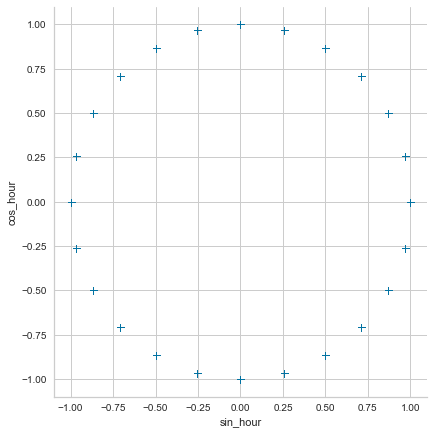

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=6, aspect=1)

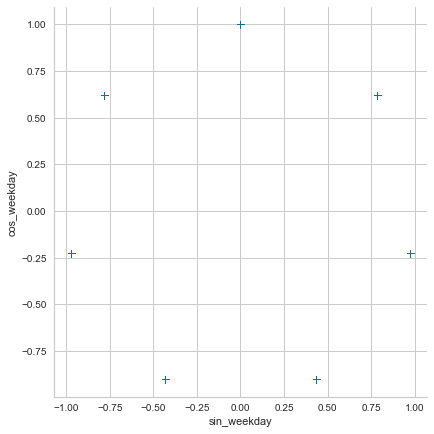

In [7]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=df, marker='+', height=6, aspect=1)

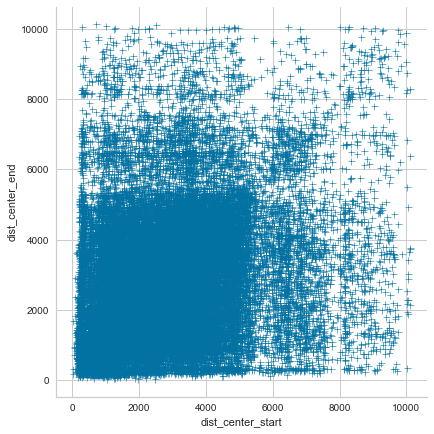

In [8]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)
#df = df.drop(df[(df['dist_center_start']>11000)&(df['dist_center_end']>11000)].index, inplace=True)

# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=6, aspect=1)

### Feature scaling

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'weekday'),
  Text(5, 0, 'weekend'),
  Text(6, 0, 'sin_hour'),
  Text(7, 0, 'cos_hour'),
  Text(8, 0, 'sin_weekday'),
  Text(9, 0, 'cos_weekday')])

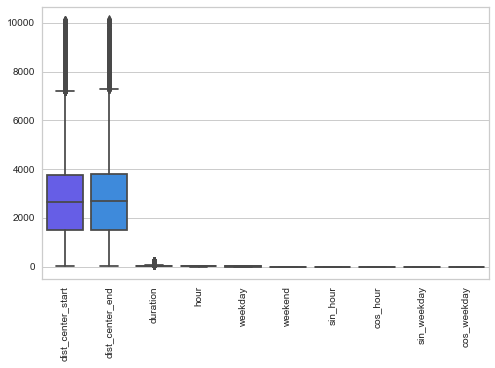

In [9]:
# look at feature skewness
plt.figure(figsize=(8,5))
sns.boxplot(data=df, palette='rainbow')
plt.xticks(rotation=90)

In [10]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=(.5 * (1 - .5)))

qqqq=df[['dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
selector.fit_transform(qqqq)
qqqq

,dist_center_start,dist_center_end,duration,hour,weekday,weekend
0,1986,3290,20.000000,3,2,0
1,4756,1625,50.016667,16,4,0
2,4353,525,40.000000,20,5,1
3,2169,2844,30.000000,13,3,0
4,1586,2935,25.033333,20,5,1
...,...,...,...,...,...,...
49587,5170,2023,105.300000,17,3,0
49588,2551,2016,20.016667,6,4,0
49589,4180,2845,10.000000,19,5,1
49590,8937,9096,85.000000,20,5,1


In [11]:
# normalize features to get same range as sin and cos values
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

#dfnorm = df[['dist_center_start','dist_center_end', 'duration']].copy()

dfnorm = df[['dist_center_start','dist_center_end', 'duration', 'weekend']].copy()

# column names
names = dfnorm.columns
# create scaler object
scaler = StandardScaler()
# fit data on scaler object
dfnorm = scaler.fit_transform(dfnorm)
dfnorm = pd.DataFrame(dfnorm, columns=names)
# normalize data
dfnorm = normalize(dfnorm) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour','sin_weekday','cos_weekday']].copy()
scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
scaled_df

# assign weight to variables to compensate for double appearance of time related features
feature_weight = 1.5
feature_weight2 = 2

scaled_df['duration'] = scaled_df['duration'] * feature_weight2
scaled_df['dist_center_start'] = scaled_df['dist_center_start'] * feature_weight
scaled_df['dist_center_end'] = scaled_df['dist_center_end'] * feature_weight

scaled_df['sin_weekday'] = scaled_df['sin_weekday'] / 1.5
scaled_df['cos_weekday'] = scaled_df['cos_weekday'] / 1.5

scaled_df['weekend'] = scaled_df['weekend'] / 1

# square std to check variance of features
scaled_df.std()*scaled_df.std()

sin_hour             0.516022
cos_hour             0.383823
sin_weekday          0.223447
cos_weekday          0.218959
dist_center_start    0.547310
dist_center_end      0.555899
duration             0.628198
weekend              0.331088
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'sin_weekday'),
  Text(3, 0, 'cos_weekday'),
  Text(4, 0, 'dist_center_start'),
  Text(5, 0, 'dist_center_end'),
  Text(6, 0, 'duration'),
  Text(7, 0, 'weekend')])

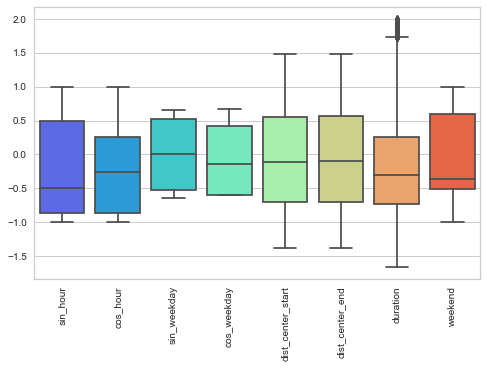

In [12]:
# visualize scaled features
plt.figure(figsize=(8,5))
sns.boxplot(data=scaled_df, palette='rainbow')
plt.xticks(rotation=90)

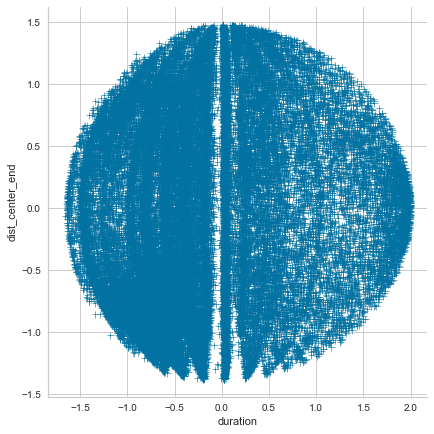

In [13]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="duration", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=6, aspect=1)

### Cluster tendency

In [14]:
# calculate hopkins statistics on subset
from pyclustertend import hopkins
#hopkins(scaled_df, 10000)

### Clustering trip types via k-means and parameter selection

#### Parameter selection / clustering performance evaluation

In [15]:
# run k-means multiple times to identify "optimal" k
from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

max_num_cluster = 30

# run loop
for i in range (2,max_num_cluster):   
    start = time.time()
    print(i)
    
    kmeans = KMeans(n_clusters=i, n_init=10) #############20
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print('inertia: ', kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print('silhouette: ',score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print('calinski harabasz: ',score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print('davies bouldin: ',score_db)

    end = time.time()
    print(end - start)

2
inertia:  139736.48599418375
silhouette:  0.16756500931961704
calinski harabasz:  10330.043404273927
davies bouldin:  2.167973795800139
66.91240668296814
3
inertia:  121709.5092350147
silhouette:  0.18110654597560197
calinski harabasz:  9602.375142707822
davies bouldin:  1.8644197872187256
63.33882522583008
4
inertia:  107948.57921651506
silhouette:  0.19439062937736515
calinski harabasz:  9324.5975364273
davies bouldin:  1.7018946981085001
61.403972148895264
5
inertia:  99750.76143911543
silhouette:  0.18137565306661976
calinski harabasz:  8586.814157681729
davies bouldin:  1.711141773099639
61.92712354660034
6
inertia:  93059.80571315635
silhouette:  0.1816138028688714
calinski harabasz:  8076.2872507848615
davies bouldin:  1.713244516379187
61.82492542266846
7
inertia:  87855.92865795888
silhouette:  0.1836943121119578
calinski harabasz:  7618.222885531634
davies bouldin:  1.7609249091502812
63.4002161026001
8
inertia:  82772.5771216555
silhouette:  0.18635820482052107
calinski ha

#### Elbow method

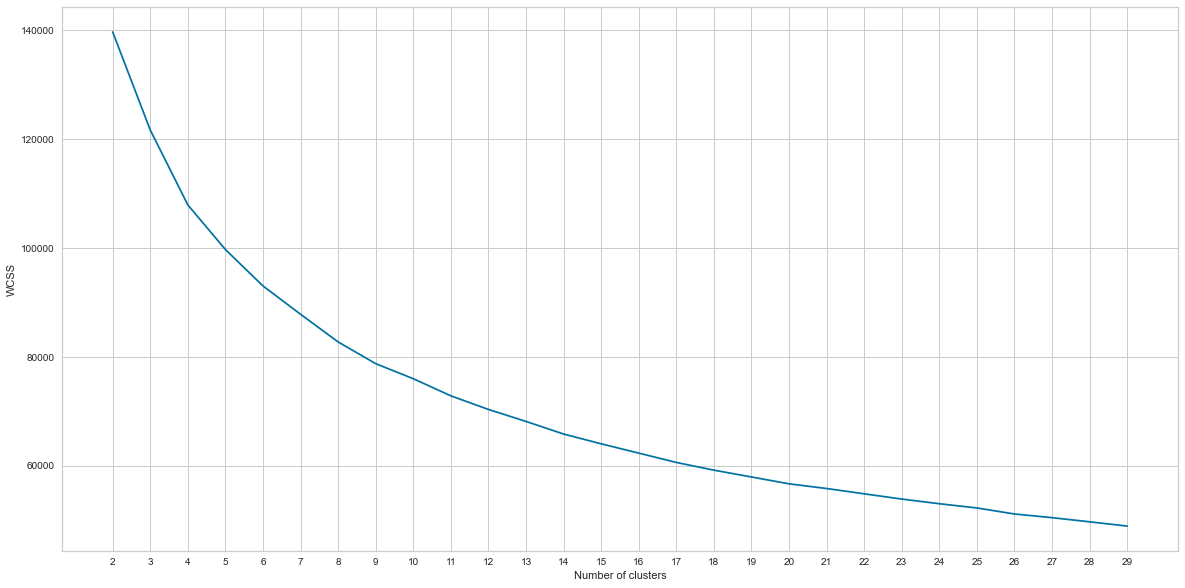

In [16]:
# plot wcss for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), wcss)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

#### Silhouette coefficient

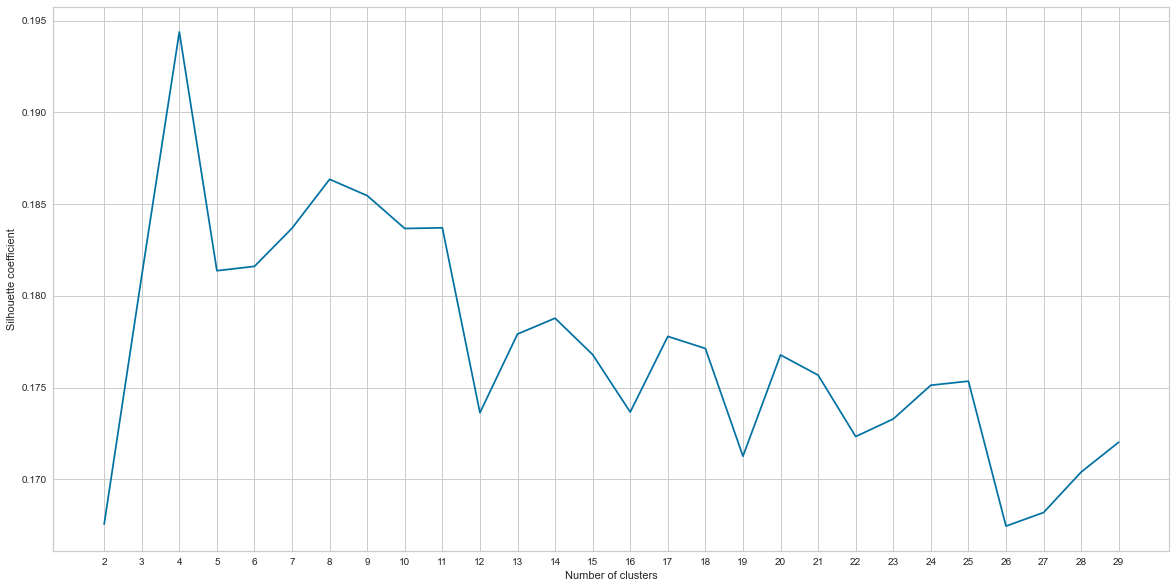

In [17]:
# plot silhouette coefficients for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), silhouette_coefficients)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

In [18]:
# silhouette score EXTREMELY high running time
if (False):
    model = KMeans(random_state=0)

    # select range of cluster number and the metric to observe costs
    visualizer = KElbowVisualizer(model, k=(2,40), metric='silhouette', timings=False)

    # fit and visualize
    visualizer.fit(scaled_df)    
    visualizer.poof()

#### Calinski Harabasz score

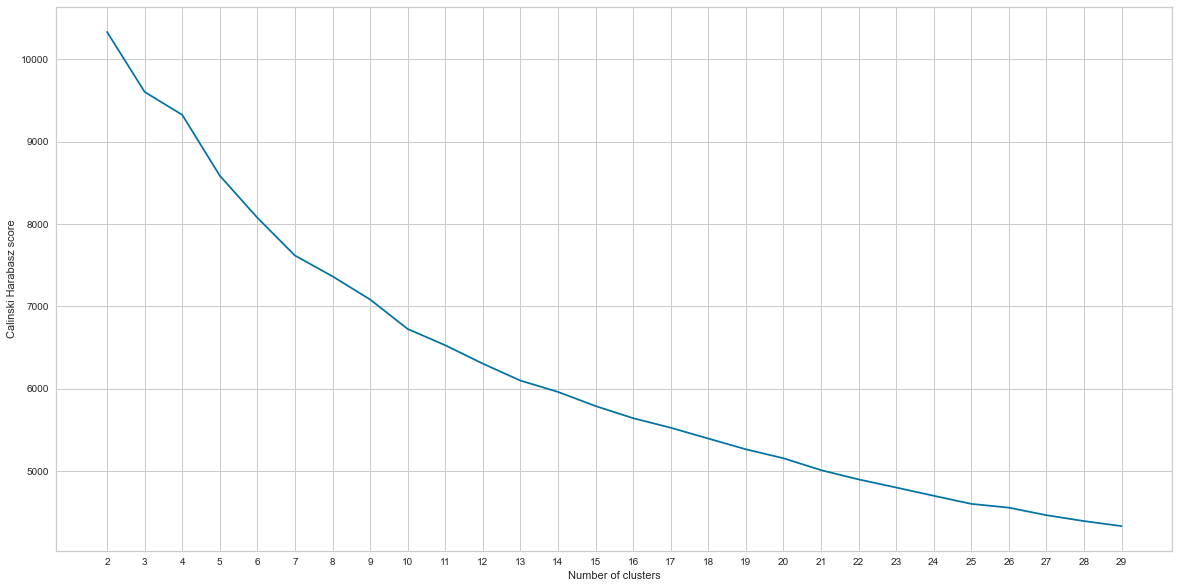

In [19]:
# plot Calinski Harabasz score for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), calinski_harabasz_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()

#### Davies Bouldin index

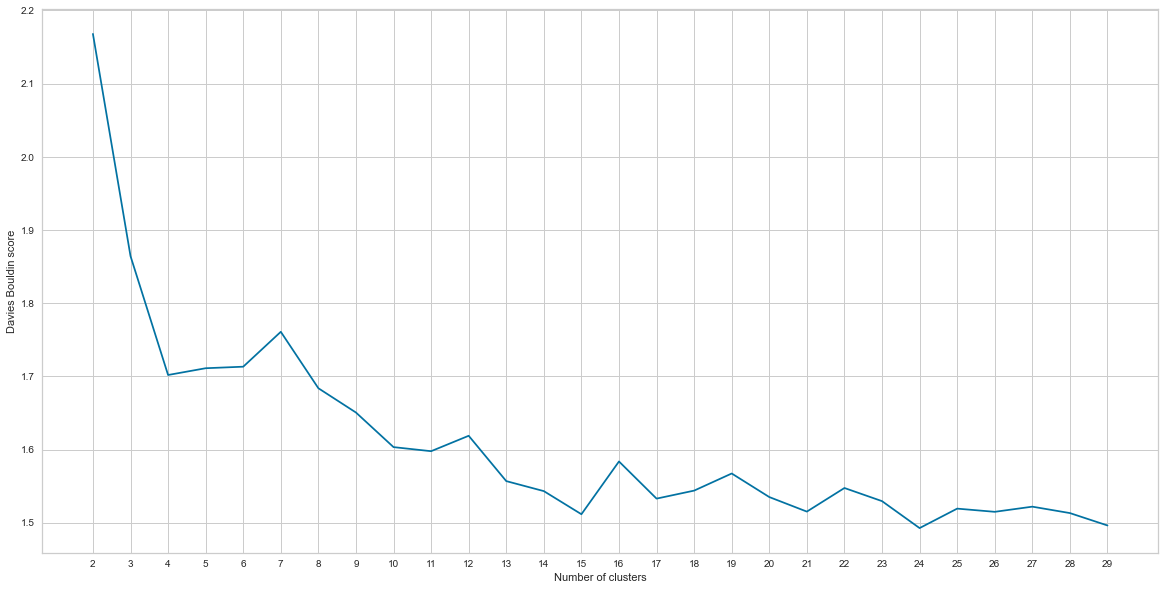

In [20]:
# plot Davies Bouldin scores for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), davies_bouldin_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()

#### K-means with selected parameter

In [21]:
# cluster data for the chosen number of clusters
k = 17

kmeans = KMeans(n_clusters=k,  n_init=20, random_state=0).fit(scaled_df)

clustered_data = df.copy()

clustered_data['cluster'] = kmeans.fit_predict(scaled_df)


clustered_data.head()

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,3,2,0,0.707107,0.707107,0.974928,-0.222521,10
1,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,16,4,0,-0.866025,-0.500000,-0.433884,-0.900969,5
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,20,5,1,-0.866025,0.500000,-0.974928,-0.222521,12
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,13,3,0,-0.258819,-0.965926,0.433884,-0.900969,3
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,20,5,1,-0.866025,0.500000,-0.974928,-0.222521,12


### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

#### Cluster cardinality

<AxesSubplot:xlabel='cluster', ylabel='count'>

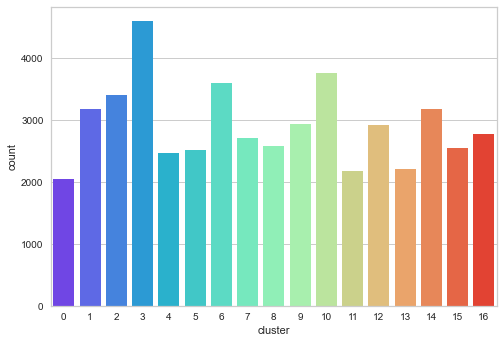

In [22]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Cluster magnitude

In [23]:

#distances = kmeans.fit_transform(scaled_df)
#variance = 0
#i = 0
#for label in kmeans.labels_:
#    variance = variance + distances[i][label]
#    i = i + 1
#variance

#for kmeans.labels_
#inertia_0

#### Cardinality vs magnitude

#### Attribute table

In [25]:
interpret_df = clustered_data[['dist_center_start','dist_center_end','duration', 'weekend','cluster']].copy()
interpret_df = interpret_df.groupby(['cluster']).mean()


time_df = clustered_data[['weekday','hour','cluster']].copy()

dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
time_df = time_df.join(pd.get_dummies(time_df['weekday']))
time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

interpret_df = interpret_df.join(time_df)

interpret_df['morning 6-12'] = interpret_df[6] + interpret_df[7] + interpret_df[8] + interpret_df[9] + interpret_df[10] + interpret_df[11] + interpret_df[12]
interpret_df['evening 13-20'] = interpret_df[14] + interpret_df[15] + interpret_df[16] + interpret_df[17] + interpret_df[18] + interpret_df[19] + interpret_df[20]


pd.set_option("display.max_rows", None, "display.max_columns", None)
interpret = interpret_df
#interpret_df.T.round(2).to_excel("1SSSSSS-InterpretClusters.xlsx")  
#interpret = interpret[(interpret['dist_center_start']>3000)&(interpret['dist_center_end']>3000)]
interpret.T.round(2)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
dist_center_start,3076.91,1666.38,2506.88,1403.51,3954.24,4631.60,1732.87,4982.51,4637.66,1499.97,1537.81,4162.78,2406.98,2269.47,4306.45,3151.92,2918.72
dist_center_end,2907.06,1813.17,2280.55,1436.10,4226.88,1701.98,1857.89,4799.00,4112.46,4215.63,1626.56,1243.30,2795.65,5422.31,4023.01,3244.59,2913.10
duration,91.53,15.48,22.13,17.17,18.12,32.88,21.00,32.39,21.52,31.10,15.64,32.01,19.82,35.27,30.68,12.39,85.62
weekend,0.17,0.00,1.00,0.00,0.01,0.01,1.00,0.00,0.04,0.01,0.00,0.02,1.00,0.08,1.00,0.00,0.17
0 Monday,14.52,17.12,0.00,18.66,19.26,17.32,0.00,17.88,18.35,17.24,19.36,18.04,0.00,18.06,0.00,18.03,14.85
1 Tuesday,16.42,17.31,0.00,18.99,18.20,16.16,0.00,19.50,19.21,17.99,21.49,18.87,0.00,18.78,0.00,20.35,14.89
2 Wednesday,15.35,19.36,0.00,18.92,18.69,17.12,0.00,20.49,17.85,19.25,18.50,21.54,0.00,16.66,0.00,18.70,14.78
3 Thursday,18.37,18.19,0.00,19.49,18.16,19.51,0.00,19.87,20.22,20.78,20.82,20.39,0.00,19.14,0.00,20.19,16.22
4 Friday,18.66,28.01,0.00,23.95,24.99,28.50,0.00,22.26,20.57,24.09,19.83,19.47,0.00,19.59,0.00,22.74,22.35
5 Saturday,11.01,0.00,57.10,0.00,0.28,1.07,60.70,0.00,2.17,0.27,0.00,0.87,58.05,4.70,59.92,0.00,10.49


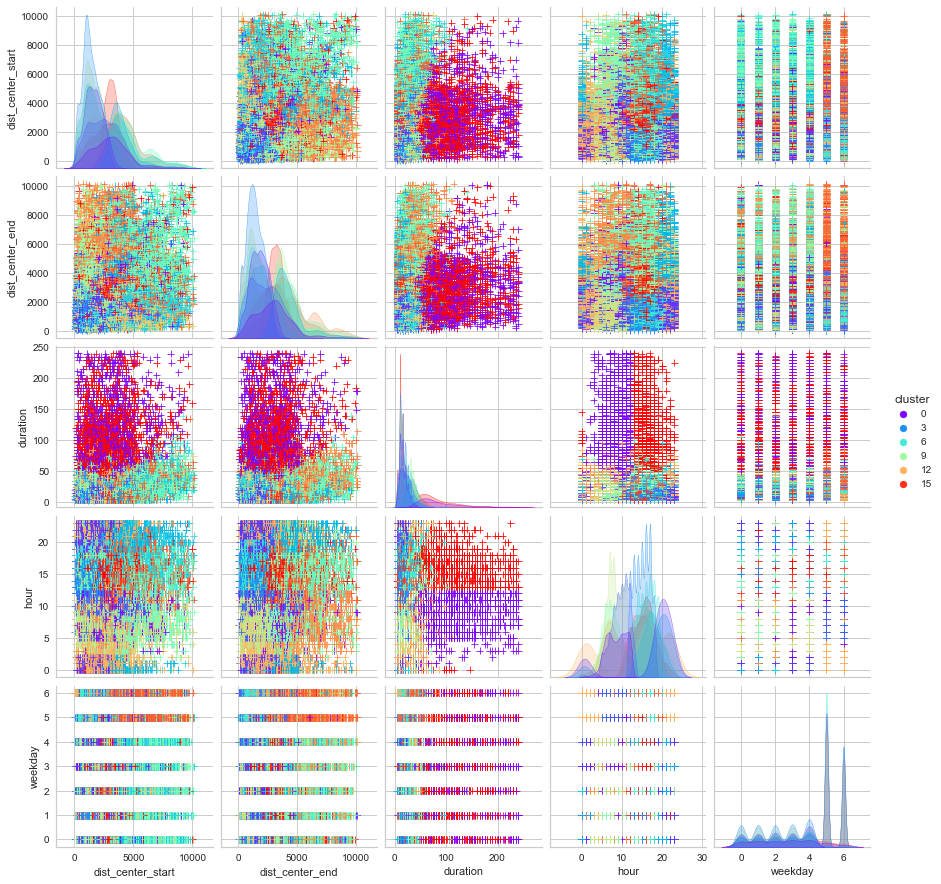

In [26]:
sns.pairplot(clustered_data[['dist_center_start','dist_center_end','duration','hour','weekday','cluster']], hue="cluster", plot_kws=dict(marker="+", linewidth=0.8), palette='rainbow')

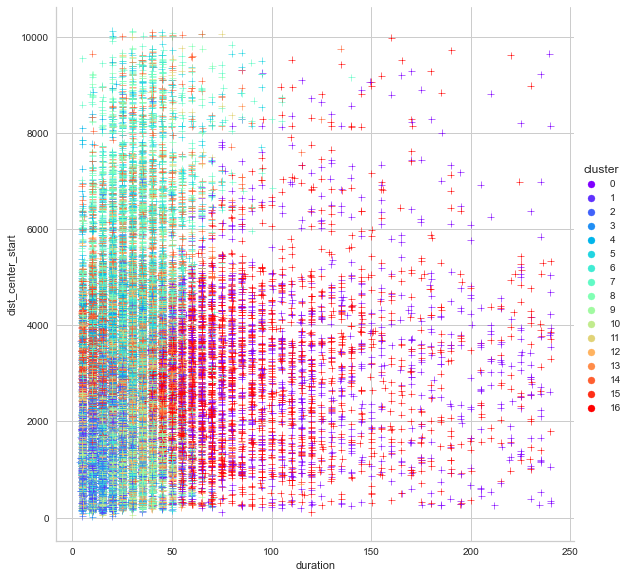

In [27]:
# plot cluster results
g = sns.relplot(x="duration", y="dist_center_start", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

<AxesSubplot:xlabel='weekday', ylabel='count'>

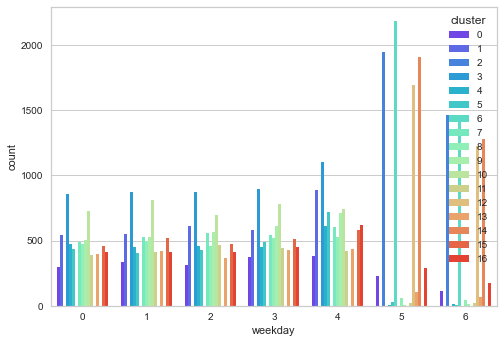

In [28]:
sns.countplot(x="weekday", data=clustered_data, hue='cluster', palette='rainbow')

In [ ]:
sampleTSNE = scaled_df.sample(n=15000, random_state=1)
# cluster data for the chosen number of clusters
k = 17
k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
clusters = k_means_new.fit_predict(sampleTSNE)
sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X = sampleTSNE.iloc[:,:-1]
##########################################
tsne = TSNE(n_components=2, perplexity=100.0, n_iter=5000, verbose=1).fit_transform(X)

tsne

In [ ]:
tsne_cluster = pd.DataFrame(tsne)
tsne_cluster['cluster'] = clusters
tsne_cluster.columns = ['x1','x2','cluster']

In [ ]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster, hue='cluster', marker='+', palette ='rainbow', legend="full", height=8, aspect=1)

### Distribution of trip types among mobility modes

In [ ]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [ ]:
create_distribution_overview('car')

In [ ]:
create_distribution_overview('bicycle')

In [ ]:
create_distribution_overview('scooter')